In [1]:
import pandas as pd
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.svm import LinearSVC
%matplotlib inline

In [2]:
sns.set_style('whitegrid')
train_data = pd.read_csv('E:/pnk/kaggle_credit/application_train.csv')

In [3]:
train_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
td_des = train_data.describe()
td_des.to_csv('E:/pnk/kaggle_credit/columns_detail.csv')

# 初步探索feature

In [24]:
#sns.countplot(x='NAME_CONTRACT_TYPE', hue='TARGET', data=train_data)
cash_data = train_data[train_data['NAME_CONTRACT_TYPE']=='Cash loans']
revolving_data = train_data[train_data['NAME_CONTRACT_TYPE']=='Revolving loans']
print ('Cash bad rate: %.6f' % (cash_data['TARGET'].sum() / len(cash_data)))
print ('Revolving bad rate: %.6f' % (revolving_data['TARGET'].sum() / len(revolving_data)))

Cash bad rate: 0.083459
Revolving bad rate: 0.054783


In [26]:
male_data = train_data[train_data['CODE_GENDER']=='M']
female_data = train_data[train_data['CODE_GENDER']=='F']
print (train_data['CODE_GENDER'].unique())
print ('Male bad rate: %.6f' % (male_data['TARGET'].sum() / len(male_data)))
print ('Female bad rate: %.6f' % (female_data['TARGET'].sum() / len(female_data)))

['M' 'F' 'XNA']
Male bad rate: 0.101419
Female bad rate: 0.069993


In [27]:
car_data = train_data[train_data['FLAG_OWN_CAR']=='Y']
nocar_data = train_data[train_data['FLAG_OWN_CAR']=='N']
print (train_data['FLAG_OWN_CAR'].unique())
print ('Car bad rate: %.6f' % (car_data['TARGET'].sum() / len(car_data)))
print ('Nocar bad rate: %.6f' % (nocar_data['TARGET'].sum() / len(nocar_data)))

['N' 'Y']
Car bad rate: 0.072437
Nocar bad rate: 0.085002


In [28]:
house_data = train_data[train_data['FLAG_OWN_REALTY']=='Y']
nohouse_data = train_data[(train_data['FLAG_OWN_REALTY']=='N')]
print (train_data['FLAG_OWN_REALTY'].unique())
print ('House bad rate: %.6f' % (house_data['TARGET'].sum() / len(house_data)))
print ('Nohouse bad rate: %.6f' % (nohouse_data['TARGET'].sum() / len(nohouse_data)))

['Y' 'N']
House bad rate: 0.079616
Nohouse bad rate: 0.083249


In [134]:
def children_redefinition(child_item):
    if int(child_item)==0:
        return '0'
    elif int(child_item)<=3:
        return '1'
    elif int(child_item)<=5:
        return '2'
    else:
        return '3'
train_data['CNT_CHILDREN_NEW'] = train_data['CNT_CHILDREN'].apply(children_redefinition)

In [135]:
children_types = train_data['CNT_CHILDREN_NEW'].unique()
for children_type in children_types:
    children_data = train_data[train_data['CNT_CHILDREN_NEW']==children_type]
    print ('Bad rate: %.6f, children %s' % ((children_data['TARGET'].sum() / len(children_data)), children_type))

Bad rate: 0.333933, children 0
Bad rate: 0.369505, children 1
Bad rate: 0.432056, children 2
Bad rate: 0.600000, children 3


In [122]:
income_3 = train_data['AMT_INCOME_TOTAL'].quantile(.75)
income_4 = train_data['AMT_INCOME_TOTAL'].quantile(.9)
income_5 = train_data['AMT_INCOME_TOTAL'].quantile(.95)
income_6 = train_data['AMT_INCOME_TOTAL'].quantile(.99)
income_data_1 = train_data[train_data['AMT_INCOME_TOTAL']<=income_3]
income_data_2 = train_data[(train_data['AMT_INCOME_TOTAL']>income_3)&(train_data['AMT_INCOME_TOTAL']<=income_4)]
income_data_3 = train_data[(train_data['AMT_INCOME_TOTAL']>income_4)&(train_data['AMT_INCOME_TOTAL']<=income_5)]
income_data_4 = train_data[(train_data['AMT_INCOME_TOTAL']>income_5)&(train_data['AMT_INCOME_TOTAL']<=income_6)]
income_data_5 = train_data[train_data['AMT_INCOME_TOTAL']>income_6]
print ('Income1 bad rate: %.6f' % (income_data_1['TARGET'].sum() / len(income_data_1)))
print ('Income2 bad rate: %.6f' % (income_data_2['TARGET'].sum() / len(income_data_2)))
print ('Income3 bad rate: %.6f' % (income_data_3['TARGET'].sum() / len(income_data_3)))
print ('Income4 bad rate: %.6f' % (income_data_4['TARGET'].sum() / len(income_data_4)))
print ('Income5 bad rate: %.6f' % (income_data_5['TARGET'].sum() / len(income_data_5)))

Income1 bad rate: 0.355483
Income2 bad rate: 0.324646
Income3 bad rate: 0.297659
Income4 bad rate: 0.272237
Income5 bad rate: 0.264526


In [124]:
GOODS_3 = train_data['AMT_GOODS_PRICE'].quantile(.75)
GOODS_4 = train_data['AMT_GOODS_PRICE'].quantile(.9)
GOODS_5 = train_data['AMT_GOODS_PRICE'].quantile(.95)
GOODS_6 = train_data['AMT_GOODS_PRICE'].quantile(.99)
GOODS_data_1 = train_data[train_data['AMT_GOODS_PRICE']<=GOODS_3]
GOODS_data_2 = train_data[(train_data['AMT_GOODS_PRICE']>GOODS_3)&(train_data['AMT_GOODS_PRICE']<=GOODS_4)]
GOODS_data_3 = train_data[(train_data['AMT_GOODS_PRICE']>GOODS_4)&(train_data['AMT_GOODS_PRICE']<=GOODS_5)]
GOODS_data_4 = train_data[(train_data['AMT_GOODS_PRICE']>GOODS_5)&(train_data['AMT_GOODS_PRICE']<=GOODS_6)]
GOODS_data_5 = train_data[train_data['AMT_GOODS_PRICE']>GOODS_6]
print ('GOODS_data_1 bad rate: %.6f' % (GOODS_data_1['TARGET'].sum() / len(GOODS_data_1)))
print ('GOODS_data_2 bad rate: %.6f' % (GOODS_data_2['TARGET'].sum() / len(GOODS_data_2)))
print ('GOODS_data_3 bad rate: %.6f' % (GOODS_data_3['TARGET'].sum() / len(GOODS_data_3)))
print ('GOODS_data_4 bad rate: %.6f' % (GOODS_data_4['TARGET'].sum() / len(GOODS_data_4)))
print ('GOODS_data_5 bad rate: %.6f' % (GOODS_data_5['TARGET'].sum() / len(GOODS_data_5)))

GOODS_data_1 bad rate: 0.369947
GOODS_data_2 bad rate: 0.284845
GOODS_data_3 bad rate: 0.263070
GOODS_data_4 bad rate: 0.222533
GOODS_data_5 bad rate: 0.197634


(0, 2000000)

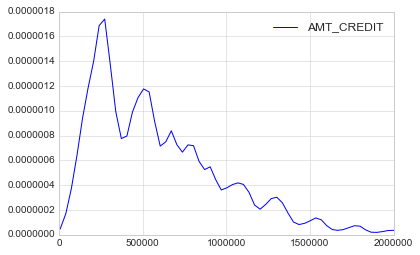

In [77]:
sns.kdeplot(train_data[(train_data['TARGET']==0)]['AMT_CREDIT'])
plt.xlim(0,2000000)

(0, 2000000)

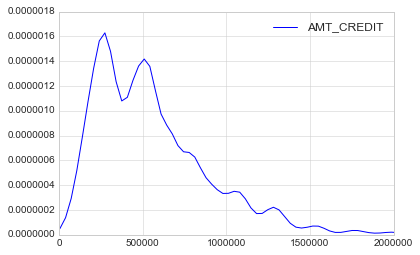

In [78]:
sns.kdeplot(train_data[(train_data['TARGET']==1)]['AMT_CREDIT'])
plt.xlim(0,2000000)

In [85]:
print 'AMT_ANNUITY,AMT_GOODS_PRICE are depend on AMT_CREDIT'

AMT_ANNUITY,AMT_GOODS_PRICE are depend on AMT_CREDIT


In [90]:
train_data['NAME_TYPE_SUITE'] = train_data['NAME_TYPE_SUITE'].fillna('Nodata')
train_data['NAME_TYPE_SUITE'].unique()

array(['Unaccompanied', 'Family', 'Spouse, partner', 'Children', 'Other_A',
       'Nodata', 'Other_B', 'Group of people'], dtype=object)

In [103]:
def acm_redefinition(acm_item):
    acm_dict = {
        'Unaccompanied': 1,
        'Family': 2,
        'Spouse, partner': 3,
        'Children': 4,
        'Other_A': 5,
        'Nodata': 6,
        'Other_B': 7,
        'Group of people': 8
    }
    if acm_item in acm_dict:
        return acm_dict[acm_item]
    else:
        return 6
train_data['NAME_TYPE_SUITE_NEW'] = train_data['NAME_TYPE_SUITE'].apply(acm_redefinition)

In [91]:
acm_types = train_data['NAME_TYPE_SUITE'].unique()
for acm_type in acm_types:
    acm_data = train_data[train_data['NAME_TYPE_SUITE']==acm_type]
    print 'Bad rate: %.6f, NAME_TYPE_SUITE %s' % ((acm_data['TARGET'].sum() / len(acm_data)), acm_type)

Bad rate: 0.081830, NAME_TYPE_SUITE Unaccompanied
Bad rate: 0.074946, NAME_TYPE_SUITE Family
Bad rate: 0.078716, NAME_TYPE_SUITE Spouse, partner
Bad rate: 0.073768, NAME_TYPE_SUITE Children
Bad rate: 0.087760, NAME_TYPE_SUITE Other_A
Bad rate: 0.054180, NAME_TYPE_SUITE Nodata
Bad rate: 0.098305, NAME_TYPE_SUITE Other_B
Bad rate: 0.084871, NAME_TYPE_SUITE Group of people


In [107]:
def intype_redefinition(in_item):
    in_dict = {
        'Working': 1,
        'State servant': 2,
        'Commercial associate': 3,
        'Pensioner': 4,
        'Unemployed': 5,
        'Student': 6,
        'Businessman': 7,
        'Maternity leave': 8
    }
    if in_item in in_dict:
        return in_dict[in_item]
    else:
        return 1
train_data['NAME_INCOME_TYPE_NEW'] = train_data['NAME_INCOME_TYPE'].apply(intype_redefinition)

In [92]:
income_types = train_data['NAME_INCOME_TYPE'].unique()
for income_type in income_types:
    income_data = train_data[train_data['NAME_INCOME_TYPE']==income_type]
    print 'Bad rate: %.6f, NAME_INCOME_TYPE %s' % ((income_data['TARGET'].sum() / len(income_data)), income_type)

Bad rate: 0.095885, NAME_INCOME_TYPE Working
Bad rate: 0.057550, NAME_INCOME_TYPE State servant
Bad rate: 0.074843, NAME_INCOME_TYPE Commercial associate
Bad rate: 0.053864, NAME_INCOME_TYPE Pensioner
Bad rate: 0.363636, NAME_INCOME_TYPE Unemployed
Bad rate: 0.000000, NAME_INCOME_TYPE Student
Bad rate: 0.000000, NAME_INCOME_TYPE Businessman
Bad rate: 0.400000, NAME_INCOME_TYPE Maternity leave


In [7]:
def edu_redefinition(edu_item):
    edu_dict = {
        'Secondary / secondary special': 1,
        'Higher education': 2,
        'Incomplete higher': 3,
        'Lower secondary': 4,
        'Academic degree': 5
    }
    if edu_item in edu_dict:
        return edu_dict[edu_item]
    else:
        return 1
train_data['NAME_EDUCATION_TYPE_NEW'] = train_data['NAME_EDUCATION_TYPE'].apply(edu_redefinition)

In [6]:
edu_types = train_data['NAME_EDUCATION_TYPE'].unique()
for edu_type in edu_types:
    edu_data = train_data[train_data['NAME_EDUCATION_TYPE']==edu_type]
    print 'Bad rate: %.6f, NAME_EDUCATION_TYPE %s' % ((edu_data['TARGET'].sum() / len(edu_data)), edu_type)

Bad rate: 0.089399, NAME_EDUCATION_TYPE Secondary / secondary special
Bad rate: 0.053551, NAME_EDUCATION_TYPE Higher education
Bad rate: 0.084850, NAME_EDUCATION_TYPE Incomplete higher
Bad rate: 0.109277, NAME_EDUCATION_TYPE Lower secondary
Bad rate: 0.018293, NAME_EDUCATION_TYPE Academic degree


In [11]:
def fms_redefinition(fms_item):
    fms_dict = {
        'Single / not married': 1,
        'Married': 2,
        'Civil marriage': 3,
        'Widow': 4,
        'Separated': 5,
        'Unknown': 6
    }
    if fms_item in fms_dict:
        return fms_dict[fms_item]
    else:
        return 1
train_data['NAME_FAMILY_STATUS_NEW'] = train_data['NAME_FAMILY_STATUS'].apply(fms_redefinition)

In [10]:
fms_types = train_data['NAME_FAMILY_STATUS'].unique()
for fms_type in fms_types:
    fms_data = train_data[train_data['NAME_FAMILY_STATUS']==fms_type]
    print 'Bad rate: %.6f, NAME_FAMILY_STATUS %s' % ((fms_data['TARGET'].sum() / len(fms_data)), fms_type)

Bad rate: 0.098077, NAME_FAMILY_STATUS Single / not married
Bad rate: 0.075599, NAME_FAMILY_STATUS Married
Bad rate: 0.099446, NAME_FAMILY_STATUS Civil marriage
Bad rate: 0.058242, NAME_FAMILY_STATUS Widow
Bad rate: 0.081942, NAME_FAMILY_STATUS Separated
Bad rate: 0.000000, NAME_FAMILY_STATUS Unknown


In [14]:
def house_redefinition(house_item):
    house_dict = {
        'House / apartment': 1,
        'Rented apartment': 2,
        'With parents': 3,
        'Municipal apartment': 4,
        'Office apartment': 5,
        'Co-op apartment': 6
    }
    if house_item in house_dict:
        return house_dict[house_item]
    else:
        return 1
train_data['NAME_HOUSING_TYPE_NEW'] = train_data['NAME_HOUSING_TYPE'].apply(house_redefinition)

In [13]:
house_types = train_data['NAME_HOUSING_TYPE'].unique()
for house_type in house_types:
    house_data = train_data[train_data['NAME_HOUSING_TYPE']==house_type]
    print 'Bad rate: %.6f, NAME_HOUSING_TYPE %s' % ((house_data['TARGET'].sum() / len(house_data)), house_type)

Bad rate: 0.077957, NAME_HOUSING_TYPE House / apartment
Bad rate: 0.123131, NAME_HOUSING_TYPE Rented apartment
Bad rate: 0.116981, NAME_HOUSING_TYPE With parents
Bad rate: 0.085397, NAME_HOUSING_TYPE Municipal apartment
Bad rate: 0.065724, NAME_HOUSING_TYPE Office apartment
Bad rate: 0.079323, NAME_HOUSING_TYPE Co-op apartment


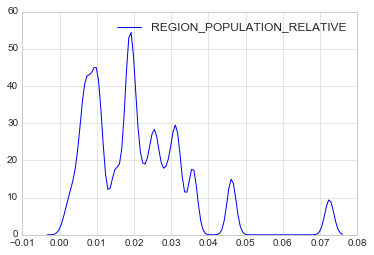

In [16]:
sns.kdeplot(train_data[(train_data['TARGET']==0)]['REGION_POPULATION_RELATIVE'])

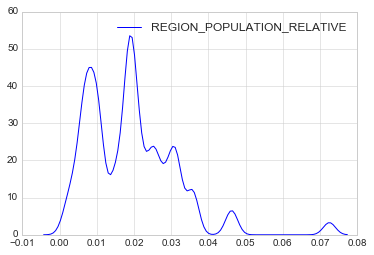

In [17]:
sns.kdeplot(train_data[(train_data['TARGET']==1)]['REGION_POPULATION_RELATIVE'])

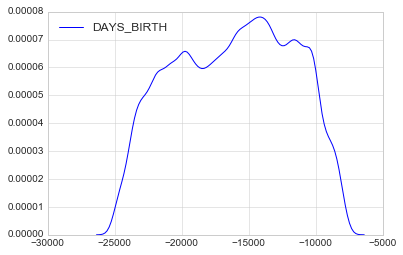

In [18]:
sns.kdeplot(train_data[(train_data['TARGET']==0)]['DAYS_BIRTH'])

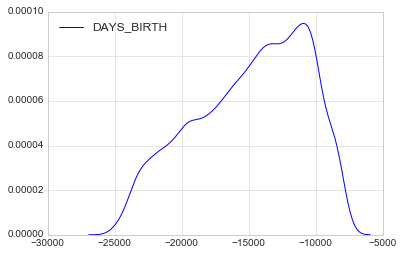

In [19]:
sns.kdeplot(train_data[(train_data['TARGET']==1)]['DAYS_BIRTH'])

In [31]:
train_data['OWN_CAR_AGE'] = train_data['OWN_CAR_AGE'].fillna(-100)

In [45]:
mobile_types = train_data['FLAG_EMP_PHONE'].unique()
for mobile_type in mobile_types:
    mobile_data = train_data[train_data['FLAG_EMP_PHONE']==mobile_type]
    print 'Bad rate: %.6f, FLAG_EMP_PHONE %s' % ((mobile_data['TARGET'].sum() / len(mobile_data)), mobile_type)

Bad rate: 0.086600, FLAG_EMP_PHONE 1
Bad rate: 0.054003, FLAG_EMP_PHONE 0


In [60]:
def ocp_redefinition(ocp_item):
    ocp_dict = {
        'Laborers': 1,
        'Core staff': 2,
        'Accountants': 3,
        'Managers': 4,
        'Nodata': 5,
        'Drivers': 6,
        'Sales staff': 7,
        'Cleaning staff': 8,
        'Cooking staff': 9,
        'Private service staff': 10,
        'Medicine staff': 11,
        'Security staff': 12,
        'High skill tech staff': 13,
        'Waiters/barmen staff': 14,
        'Low-skill Laborers': 15,
        'Realty agents': 16,
        'Secretaries': 17,
        'IT staff': 18,
        'HR staff': 19,
    }
    if ocp_item in ocp_dict:
        return ocp_dict[ocp_item]
    else:
        return 5
train_data['OCCUPATION_TYPE_NEW'] = train_data['OCCUPATION_TYPE'].apply(ocp_redefinition)

In [58]:
train_data['OCCUPATION_TYPE'] = train_data['OCCUPATION_TYPE'].fillna('Nodata')
mobile_types = train_data['OCCUPATION_TYPE'].unique()
for mobile_type in mobile_types:
    mobile_data = train_data[train_data['OCCUPATION_TYPE']==mobile_type]
    print 'Bad rate: %.6f, OCCUPATION_TYPE %s' % ((mobile_data['TARGET'].sum() / len(mobile_data)), mobile_type)

Bad rate: 0.105788, OCCUPATION_TYPE Laborers
Bad rate: 0.063040, OCCUPATION_TYPE Core staff
Bad rate: 0.048303, OCCUPATION_TYPE Accountants
Bad rate: 0.062140, OCCUPATION_TYPE Managers
Bad rate: 0.065131, OCCUPATION_TYPE Nodata
Bad rate: 0.113261, OCCUPATION_TYPE Drivers
Bad rate: 0.096318, OCCUPATION_TYPE Sales staff
Bad rate: 0.096067, OCCUPATION_TYPE Cleaning staff
Bad rate: 0.104440, OCCUPATION_TYPE Cooking staff
Bad rate: 0.065988, OCCUPATION_TYPE Private service staff
Bad rate: 0.067002, OCCUPATION_TYPE Medicine staff
Bad rate: 0.107424, OCCUPATION_TYPE Security staff
Bad rate: 0.061599, OCCUPATION_TYPE High skill tech staff
Bad rate: 0.112760, OCCUPATION_TYPE Waiters/barmen staff
Bad rate: 0.171524, OCCUPATION_TYPE Low-skill Laborers
Bad rate: 0.078562, OCCUPATION_TYPE Realty agents
Bad rate: 0.070498, OCCUPATION_TYPE Secretaries
Bad rate: 0.064639, OCCUPATION_TYPE IT staff
Bad rate: 0.063943, OCCUPATION_TYPE HR staff


In [131]:
cnt_mid = train_data['CNT_FAM_MEMBERS'].quantile(0.5)
train_data['CNT_FAM_MEMBERS'] = train_data['CNT_FAM_MEMBERS'].fillna(cnt_mid)

In [132]:
def mem_redefinition(mem_item):
    if int(mem_item)==2:
        return '2'
    else:
        return '1'
train_data['CNT_FAM_MEMBERS_NEW'] = train_data['CNT_FAM_MEMBERS'].apply(mem_redefinition)

In [133]:
children_types = train_data['CNT_FAM_MEMBERS_NEW'].unique()
for children_type in children_types:
    children_data = train_data[train_data['CNT_FAM_MEMBERS_NEW']==children_type]
    print ('Bad rate: %.6f, CNT_FAM_MEMBERS_NEW %s' % ((children_data['TARGET'].sum() / len(children_data)), children_type))

Bad rate: 0.328856, CNT_FAM_MEMBERS_NEW 2
Bad rate: 0.361814, CNT_FAM_MEMBERS_NEW 1


In [150]:
children_types = train_data['REGION_RATING_CLIENT_W_CITY'].unique()
for children_type in children_types:
    children_data = train_data[train_data['REGION_RATING_CLIENT_W_CITY']==children_type]
    print 'Bad rate: %.6f, REGION_RATING_CLIENT_W_CITY %s' % ((children_data['TARGET'].sum() / len(children_data)), children_type)

Bad rate: 0.079178, REGION_RATING_CLIENT_W_CITY 2
Bad rate: 0.048409, REGION_RATING_CLIENT_W_CITY 1
Bad rate: 0.114022, REGION_RATING_CLIENT_W_CITY 3


In [153]:
children_types = train_data['HOUR_APPR_PROCESS_START'].unique()
for children_type in children_types:
    children_data = train_data[train_data['HOUR_APPR_PROCESS_START']==children_type]
    print 'Bad rate: %.6f, HOUR_APPR_PROCESS_START %s' % ((children_data['TARGET'].sum() / len(children_data)), children_type)

Bad rate: 0.080218, HOUR_APPR_PROCESS_START 10
Bad rate: 0.080744, HOUR_APPR_PROCESS_START 11
Bad rate: 0.082055, HOUR_APPR_PROCESS_START 9
Bad rate: 0.064899, HOUR_APPR_PROCESS_START 17
Bad rate: 0.074614, HOUR_APPR_PROCESS_START 16
Bad rate: 0.079077, HOUR_APPR_PROCESS_START 14
Bad rate: 0.090765, HOUR_APPR_PROCESS_START 8
Bad rate: 0.075929, HOUR_APPR_PROCESS_START 15
Bad rate: 0.100427, HOUR_APPR_PROCESS_START 7
Bad rate: 0.080267, HOUR_APPR_PROCESS_START 13
Bad rate: 0.110407, HOUR_APPR_PROCESS_START 6
Bad rate: 0.082581, HOUR_APPR_PROCESS_START 12
Bad rate: 0.068607, HOUR_APPR_PROCESS_START 19
Bad rate: 0.086992, HOUR_APPR_PROCESS_START 3
Bad rate: 0.070173, HOUR_APPR_PROCESS_START 18
Bad rate: 0.061728, HOUR_APPR_PROCESS_START 21
Bad rate: 0.082775, HOUR_APPR_PROCESS_START 4
Bad rate: 0.105827, HOUR_APPR_PROCESS_START 5
Bad rate: 0.070234, HOUR_APPR_PROCESS_START 20
Bad rate: 0.100000, HOUR_APPR_PROCESS_START 22
Bad rate: 0.081395, HOUR_APPR_PROCESS_START 1
Bad rate: 0.098361, H

In [24]:
og_dict = {item:i for i, item in enumerate(sorted(train_data['ORGANIZATION_TYPE'].unique()))}

In [25]:
def og_redefinition(og_item):
    global og_dict
    if og_item in og_dict:
        return og_dict[og_item]
    else:
        return 57
train_data['ORGANIZATION_TYPE_NEW'] = train_data['ORGANIZATION_TYPE'].apply(og_redefinition)

In [13]:
children_types = train_data['ORGANIZATION_TYPE'].unique()
for children_type in children_types:
    children_data = train_data[train_data['ORGANIZATION_TYPE']==children_type]
    print 'Bad rate: %.6f, ORGANIZATION_TYPE %s' % ((children_data['TARGET'].sum() / len(children_data)), children_type)

Bad rate: 0.092996, ORGANIZATION_TYPE Business Entity Type 3
Bad rate: 0.059148, ORGANIZATION_TYPE School
Bad rate: 0.069781, ORGANIZATION_TYPE Government
Bad rate: 0.058824, ORGANIZATION_TYPE Religion
Bad rate: 0.076425, ORGANIZATION_TYPE Other
Bad rate: 0.053996, ORGANIZATION_TYPE XNA
Bad rate: 0.066316, ORGANIZATION_TYPE Electricity
Bad rate: 0.065845, ORGANIZATION_TYPE Medicine
Bad rate: 0.085284, ORGANIZATION_TYPE Business Entity Type 2
Bad rate: 0.101739, ORGANIZATION_TYPE Self-employed
Bad rate: 0.078040, ORGANIZATION_TYPE Transport: type 2
Bad rate: 0.116798, ORGANIZATION_TYPE Construction
Bad rate: 0.079446, ORGANIZATION_TYPE Housing
Bad rate: 0.070349, ORGANIZATION_TYPE Kindergarten
Bad rate: 0.094496, ORGANIZATION_TYPE Trade: type 7
Bad rate: 0.086538, ORGANIZATION_TYPE Industry: type 11
Bad rate: 0.051253, ORGANIZATION_TYPE Military
Bad rate: 0.066032, ORGANIZATION_TYPE Services
Bad rate: 0.048632, ORGANIZATION_TYPE Security Ministries
Bad rate: 0.092812, ORGANIZATION_TYPE 

In [28]:
#train_data[train_data['EXT_SOURCE_2'].isnull()]
source_mid = train_data['EXT_SOURCE_2'].quantile(0.5)
train_data['EXT_SOURCE_2'] = train_data['EXT_SOURCE_2'].fillna(source_mid)

In [57]:
obs30_mid = train_data['OBS_30_CNT_SOCIAL_CIRCLE'].quantile(0.5)
train_data['OBS_30_CNT_SOCIAL_CIRCLE'] = train_data['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(obs30_mid)

In [62]:
phone_mid = train_data['DAYS_LAST_PHONE_CHANGE'].quantile(0.5)
train_data['DAYS_LAST_PHONE_CHANGE'] = train_data['DAYS_LAST_PHONE_CHANGE'].fillna(phone_mid)

In [139]:
len(train_data[train_data['FLAG_DOCUMENT_21']==1])

103

In [114]:
children_types = train_data['FLAG_DOCUMENT_21'].unique()
for children_type in children_types:
    children_data = train_data[train_data['FLAG_DOCUMENT_21']==children_type]
    print 'Bad rate: %.6f, FLAG_DOCUMENT_21 %s' % ((children_data['TARGET'].sum() / len(children_data)), children_type)

Bad rate: 0.080710, FLAG_DOCUMENT_21 0
Bad rate: 0.135922, FLAG_DOCUMENT_21 1


In [133]:
train_data['AMT_REQ_CREDIT_BUREAU_HOUR'] = train_data['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(0)

In [131]:
children_types = train_data['AMT_REQ_CREDIT_BUREAU_HOUR'].unique()
for children_type in children_types:
    children_data = train_data[train_data['AMT_REQ_CREDIT_BUREAU_HOUR']==children_type]
    if len(children_data)==0:
        continue
    print 'Bad rate: %.6f, AMT_REQ_CREDIT_BUREAU_HOUR %s' % ((children_data['TARGET'].sum() / len(children_data)), children_type)

Bad rate: 0.077173, AMT_REQ_CREDIT_BUREAU_HOUR 0.0
Bad rate: 0.080128, AMT_REQ_CREDIT_BUREAU_HOUR 1.0
Bad rate: 0.107143, AMT_REQ_CREDIT_BUREAU_HOUR 2.0
Bad rate: 0.000000, AMT_REQ_CREDIT_BUREAU_HOUR 3.0
Bad rate: 0.000000, AMT_REQ_CREDIT_BUREAU_HOUR 4.0


(-5, 25)

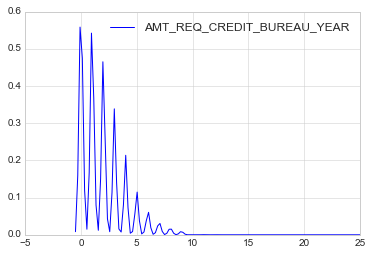

In [136]:
sns.kdeplot(train_data[train_data['TARGET']==0]['AMT_REQ_CREDIT_BUREAU_YEAR'])
plt.xlim(-5,25)

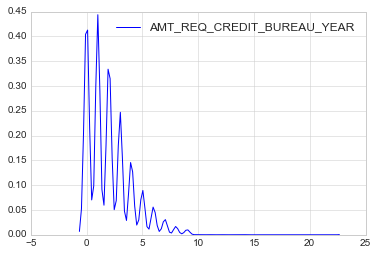

In [134]:
sns.kdeplot(train_data[train_data['TARGET']==1]['AMT_REQ_CREDIT_BUREAU_YEAR'])

In [43]:
features = ['NAME_CONTRACT_TYPE_NEW','CODE_GENDER_NEW','FLAG_OWN_REALTY_NEW','CNT_CHILDREN_NEW','AMT_INCOME_TOTAL',
           'AMT_CREDIT','NAME_TYPE_SUITE_NEW','NAME_INCOME_TYPE_NEW','NAME_EDUCATION_TYPE_NEW','NAME_FAMILY_STATUS_NEW',
           'NAME_HOUSING_TYPE_NEW','REGION_POPULATION_RELATIVE','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION',
           'DAYS_ID_PUBLISH','OWN_CAR_AGE','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE','OCCUPATION_TYPE_NEW',
            'CNT_FAM_MEMBERS_NEW','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY','HOUR_APPR_PROCESS_START',
           'REG_REGION_NOT_LIVE_REGION','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY',
           'ORGANIZATION_TYPE_NEW','EXT_SOURCE_2','OBS_30_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE','FLAG_DOCUMENT_2',
           'FLAG_DOCUMENT_3','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_9','FLAG_DOCUMENT_11','FLAG_DOCUMENT_13',
           'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_21',
           'AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK']

In [38]:
first_ctcols = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE',
                'REGION_POPULATION_RELATIVE','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH',
                'CNT_FAM_MEMBERS','HOUR_APPR_PROCESS_START','EXT_SOURCE_2','OBS_30_CNT_SOCIAL_CIRCLE',
                'DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE',
                'AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
                'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT']
fillmid_cols = ['AMT_ANNUITY','AMT_GOODS_PRICE','CNT_FAM_MEMBERS','EXT_SOURCE_2',
               'OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE',
               'DAYS_LAST_PHONE_CHANGE','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
               'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT']
def fill_withmid(origin_data, fillmid_cols):
    for i in fillmid_cols:
        mid_value = origin_data[i].quantile(.5)
        origin_data[i].fillna(mid_value,inplace=True)
    return

In [88]:
svc_data = train_data[first_ctcols].copy()
svc_target = train_data['TARGET'].as_matrix()
svc_target = np.array(list(map(lambda x:1 if x>0 else -1, svc_target)))
fill_withmid(svc_data, fillmid_cols)
svc_matrix = preprocessing.scale(svc_data)

In [144]:
lsvc = LinearSVC(penalty="l2", dual=True).fit(svc_matrix, svc_target)
#model = SelectFromModel(lsvc, prefit=True)
#svc_new = model.transform(svc_matrix)
#svc_new.shape

In [155]:
lsvc.coef_

array([[ 0.02048633, -0.02811969,  0.44182685,  0.05727355, -0.50212435,
        -0.00903545,  0.06365194, -0.02455176,  0.02200121,  0.03711006,
        -0.02950827, -0.00616669, -0.21775068,  0.09794829,  0.03198087,
        -0.09541422,  0.01109715,  0.0308493 ,  0.00434979,  0.0137986 ,
        -0.00201565, -0.00648457, -0.00747209]])

In [148]:
svc_data.columns[[20, 18, 11, 21, 22,  5, 16, 19,  0,  8,  7,  1, 10, 17, 14,  9,  3,
         6, 15, 13, 12,  2,  4]]

Index(['AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'HOUR_APPR_PROCESS_START', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'REGION_POPULATION_RELATIVE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_DAY', 'CNT_CHILDREN',
       'DAYS_REGISTRATION', 'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL',
       'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DAYS_ID_PUBLISH', 'AMT_ANNUITY', 'DAYS_BIRTH',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2',
       'AMT_CREDIT', 'AMT_GOODS_PRICE'],
      dtype='object')

In [158]:
svc_matrix[0:20][:,7]

array([-0.4494258 , -0.43551522, -0.42760629,  2.2644185 , -0.44843902,
        2.2644185 , -0.42985967, -0.49631233, -0.42605249, -0.43468309,
        2.2644185 ,  2.2644185 ,  2.2644185 ,  2.2644185 , -0.42846052,
       -0.43330602, -0.43310719,  2.2644185 , -0.43680392,  2.2644185 ])

In [35]:
first_chi2cols = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE'
                 ,'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START'
                 ,'ORGANIZATION_TYPE','FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE'
                 ,'FLAG_EMAIL','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_LIVE_REGION'
                 ,'REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY'
                 ,'REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY','FLAG_DOCUMENT_2','FLAG_DOCUMENT_3'
                 ,'FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7'
                 ,'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11'
                 ,'FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15'
                 ,'FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19'
                 ,'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']
dummy_features = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE',
                  'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE',
                 'WEEKDAY_APPR_PROCESS_START','ORGANIZATION_TYPE']
def get_cat_dummy(origin_data, dummy_features):
    return pd.get_dummies(origin_data, prefix=dummy_features, columns=dummy_features)
def get_cat_features(origin_data, cat_features, dummy_features, k=15):
    model_chi = SelectKBest(chi2, k=k)
    chi_data = origin_data[cat_features]
    chi_target = origin_data['TARGET']
    chi_matrix = get_cat_dummy(chi_data, dummy_features)
    model_chi.fit(chi_matrix, chi_target)
    return chi_matrix.columns[model_chi.pvalues_.argsort()[0:k]]

In [67]:
get_cat_features(train_data, first_chi2cols, dummy_features, k=30)

Index(['NAME_EDUCATION_TYPE_Higher education', 'NAME_INCOME_TYPE_Pensioner',
       'ORGANIZATION_TYPE_XNA', 'CODE_GENDER_M', 'REG_CITY_NOT_WORK_CITY',
       'NAME_INCOME_TYPE_Working', 'REG_CITY_NOT_LIVE_CITY',
       'OCCUPATION_TYPE_Laborers', 'CODE_GENDER_F',
       'NAME_CONTRACT_TYPE_Revolving loans', 'LIVE_CITY_NOT_WORK_CITY',
       'OCCUPATION_TYPE_Drivers', 'FLAG_DOCUMENT_6',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_HOUSING_TYPE_With parents', 'ORGANIZATION_TYPE_Self-employed',
       'NAME_INCOME_TYPE_State servant', 'FLAG_WORK_PHONE',
       'NAME_FAMILY_STATUS_Single / not married',
       'OCCUPATION_TYPE_Low-skill Laborers', 'OCCUPATION_TYPE_Accountants',
       'FLAG_DOCUMENT_3', 'REGION_RATING_CLIENT_W_CITY',
       'ORGANIZATION_TYPE_Business Entity Type 3', 'REGION_RATING_CLIENT',
       'FLAG_PHONE', 'NAME_FAMILY_STATUS_Civil marriage',
       'ORGANIZATION_TYPE_Construction', 'FLAG_EMP_PHONE',
       'NAME_FAMILY_STATUS_Widow'],
   

# 空值处理、分类变量重定义

In [44]:
cnt_mid = train_data['CNT_FAM_MEMBERS'].quantile(0.5)
train_data['CNT_FAM_MEMBERS'] = train_data['CNT_FAM_MEMBERS'].fillna(cnt_mid)
source_mid = train_data['EXT_SOURCE_2'].quantile(0.5)
train_data['EXT_SOURCE_2'] = train_data['EXT_SOURCE_2'].fillna(source_mid)
obs30_mid = train_data['OBS_30_CNT_SOCIAL_CIRCLE'].quantile(0.5)
train_data['OBS_30_CNT_SOCIAL_CIRCLE'] = train_data['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(obs30_mid)
phone_mid = train_data['DAYS_LAST_PHONE_CHANGE'].quantile(0.5)
train_data['DAYS_LAST_PHONE_CHANGE'] = train_data['DAYS_LAST_PHONE_CHANGE'].fillna(phone_mid)
train_data['AMT_REQ_CREDIT_BUREAU_HOUR'] = train_data['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(0)
train_data['AMT_REQ_CREDIT_BUREAU_DAY'] = train_data['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(0)
train_data['AMT_REQ_CREDIT_BUREAU_WEEK'] = train_data['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(0)
train_data['NAME_TYPE_SUITE'] = train_data['NAME_TYPE_SUITE'].fillna('Nodata')
train_data['OCCUPATION_TYPE'] = train_data['OCCUPATION_TYPE'].fillna('Nodata')
train_data['OWN_CAR_AGE'] = train_data['OWN_CAR_AGE'].fillna(-100)
og_dict = {item:i for i, item in enumerate(sorted(train_data['ORGANIZATION_TYPE'].unique()))}

In [45]:
def contract_redefinition(contract_item):
    if contract_item=='Cash loans':
        return 0
    else:
        return 1
train_data['NAME_CONTRACT_TYPE_NEW'] = train_data['NAME_CONTRACT_TYPE'].apply(contract_redefinition)
def gender_redefinition(gender_item):
    if gender_item=='M':
        return 0
    elif gender_item=='F':
        return 1
    else:
        return 2
train_data['CODE_GENDER_NEW'] = train_data['CODE_GENDER'].apply(gender_redefinition)
def rea_redefinition(rea_item):
    if rea_item=='N':
        return 0
    else:
        return 1
train_data['FLAG_OWN_REALTY_NEW'] = train_data['FLAG_OWN_REALTY'].apply(rea_redefinition)
def children_redefinition(child_item):
    if int(child_item)==0:
        return 0
    elif int(child_item)<=3:
        return 1
    elif int(child_item)<=5:
        return 2
    else:
        return 3
train_data['CNT_CHILDREN_NEW'] = train_data['CNT_CHILDREN'].apply(children_redefinition)
def acm_redefinition(acm_item):
    acm_dict = {
        'Unaccompanied': 1,
        'Family': 2,
        'Spouse, partner': 3,
        'Children': 4,
        'Other_A': 5,
        'Nodata': 6,
        'Other_B': 7,
        'Group of people': 8
    }
    if acm_item in acm_dict:
        return acm_dict[acm_item]
    else:
        return 6
train_data['NAME_TYPE_SUITE_NEW'] = train_data['NAME_TYPE_SUITE'].apply(acm_redefinition)
def intype_redefinition(in_item):
    in_dict = {
        'Working': 1,
        'State servant': 2,
        'Commercial associate': 3,
        'Pensioner': 4,
        'Unemployed': 5,
        'Student': 6,
        'Businessman': 7,
        'Maternity leave': 8
    }
    if in_item in in_dict:
        return in_dict[in_item]
    else:
        return 1
train_data['NAME_INCOME_TYPE_NEW'] = train_data['NAME_INCOME_TYPE'].apply(intype_redefinition)
def edu_redefinition(edu_item):
    edu_dict = {
        'Secondary / secondary special': 1,
        'Higher education': 2,
        'Incomplete higher': 3,
        'Lower secondary': 4,
        'Academic degree': 5
    }
    if edu_item in edu_dict:
        return edu_dict[edu_item]
    else:
        return 1
train_data['NAME_EDUCATION_TYPE_NEW'] = train_data['NAME_EDUCATION_TYPE'].apply(edu_redefinition)
def fms_redefinition(fms_item):
    fms_dict = {
        'Single / not married': 1,
        'Married': 2,
        'Civil marriage': 3,
        'Widow': 4,
        'Separated': 5,
        'Unknown': 6
    }
    if fms_item in fms_dict:
        return fms_dict[fms_item]
    else:
        return 1
train_data['NAME_FAMILY_STATUS_NEW'] = train_data['NAME_FAMILY_STATUS'].apply(fms_redefinition)
def house_redefinition(house_item):
    house_dict = {
        'House / apartment': 1,
        'Rented apartment': 2,
        'With parents': 3,
        'Municipal apartment': 4,
        'Office apartment': 5,
        'Co-op apartment': 6
    }
    if house_item in house_dict:
        return house_dict[house_item]
    else:
        return 1
train_data['NAME_HOUSING_TYPE_NEW'] = train_data['NAME_HOUSING_TYPE'].apply(house_redefinition)
def ocp_redefinition(ocp_item):
    ocp_dict = {
        'Laborers': 1,
        'Core staff': 2,
        'Accountants': 3,
        'Managers': 4,
        'Nodata': 5,
        'Drivers': 6,
        'Sales staff': 7,
        'Cleaning staff': 8,
        'Cooking staff': 9,
        'Private service staff': 10,
        'Medicine staff': 11,
        'Security staff': 12,
        'High skill tech staff': 13,
        'Waiters/barmen staff': 14,
        'Low-skill Laborers': 15,
        'Realty agents': 16,
        'Secretaries': 17,
        'IT staff': 18,
        'HR staff': 19,
    }
    if ocp_item in ocp_dict:
        return ocp_dict[ocp_item]
    else:
        return 5
train_data['OCCUPATION_TYPE_NEW'] = train_data['OCCUPATION_TYPE'].apply(ocp_redefinition)
def mem_redefinition(mem_item):
    if int(mem_item)==2:
        return 2
    else:
        return 1
train_data['CNT_FAM_MEMBERS_NEW'] = train_data['CNT_FAM_MEMBERS'].apply(mem_redefinition)
def og_redefinition(og_item):
    global og_dict
    if og_item in og_dict:
        return og_dict[og_item]
    else:
        return 57
train_data['ORGANIZATION_TYPE_NEW'] = train_data['ORGANIZATION_TYPE'].apply(og_redefinition)

In [46]:
train_data = train_data[features+['TARGET']]

# 数据不平衡，重采样

In [61]:
print (train_data['TARGET'].sum(), len(train_data)-train_data['TARGET'].sum())

24825 282686


In [62]:
np.random.seed(1)
safe_data = train_data[train_data['TARGET']==0]
bad_data = train_data[train_data['TARGET']==1]
safe_part_index = np.random.randint(low=0, high=len(safe_data),size=94228)
safe_data.reset_index(drop=True,inplace=True)
safe_data = safe_data.loc[safe_part_index]
bad_data = pd.concat([bad_data,bad_data])

In [63]:
print (len(safe_data),len(bad_data))

94228 49650


In [64]:
train_data = pd.concat([safe_data,bad_data])

# 模型参数选择

In [11]:
import sklearn
from sklearn.cross_validation import train_test_split

In [47]:
total_x = train_data[features].as_matrix()
total_y = train_data['TARGET'].as_matrix()

In [48]:
X_train, X_test, y_train, y_test = train_test_split(total_x, total_y, test_size=0.2, random_state=1)

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
model_1 = DecisionTreeClassifier()
tuned_parameters = [{'max_depth': [5,10,20,50,100], 
                     'min_samples_split': [2,7,10,50,100,300],
                     'random_state': [1]
                     }]
clf = GridSearchCV(model_1, tuned_parameters, cv=5,
                       scoring='roc_auc')

In [17]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'min_samples_split': [2, 7, 10, 50, 100, 300], 'random_state': [1], 'max_depth': [5, 10, 20, 50, 100]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [20]:
clf.best_params_

{'max_depth': 50, 'min_samples_split': 2, 'random_state': 1}

In [21]:
model_2 = DecisionTreeClassifier(max_depth=50,min_samples_split=2,random_state=1)
model_2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [57]:
y_pred = model_2.predict(X_test)

In [53]:
y_pred = model_2.predict_proba(X_test)

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

In [62]:
roc_auc_score(y_test,y_pred)

0.89472312978573698

In [49]:
print y_test.sum(), len(y_test)

4970 61503


In [38]:
clf.best_score_

0.67399977817142742

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
model_1 = DecisionTreeClassifier()
tuned_parameters2 = [{'max_depth': [5,8,15,20], 
                     'min_samples_split': [2,7,10,15,70,300]
                     }]
clf2 = GridSearchCV(model_1, tuned_parameters2, cv=10,
                       scoring='roc_auc')

In [42]:
clf2.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'min_samples_split': [2, 7, 10, 15, 70, 300], 'max_depth': [5, 8, 15, 20]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [44]:
clf2.best_params_

{'max_depth': 8, 'min_samples_split': 300}